<div class='container' style='border-bottom: 1px solid; width:100%'>
    <div style='float:left'>
    Bernat Esquirol & Pere Gilabert 
    </div>
    <div style='float:right'>
    Optimization 2019
    </div>
</div>

# Delivery 01: Visualization and Metrics

## Data

The data we've used to build our network are Spotify bands and playlists. Through API calls we have managed to download about 20,000 playlists with the respective artists performing each of the songs.

As a result, there are two different types of nodes in this network:
* Playlist node
* Artist node

Since we have these two types of nodes, we have built a bipartite graph. 

## Graph

### Read the data

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from matplotlib import pyplot as plt

%matplotlib inline

songs = pd.read_pickle('../data/songs.pkl')
songs['artist']=songs['artists'].apply(lambda x: x[0][1])

### Creating the graph

In [12]:
# Create a default graph
spotify = nx.Graph()

# Read the playlists from a file
playlists = pd.read_pickle('../data/final_spotify_playlists.pkl')

print("{:d} playlists ready to be added to the network".format(len(playlists.index)))

# We add two different types of nodes 
spotify.add_nodes_from(playlists.index, bipartite=0)
spotify.add_nodes_from(songs['artist'].unique(), bipartite=1)

# The edges are created here
print("Adding nodes...", end="")
for artist, group in songs[['artist','playlists']].groupby('artist'):
    for playlists in group['playlists'].values:
        for playlist in playlists:
            spotify.add_edge(artist, playlist)
print("DONE")

# Remove lonely nodes
spotify.remove_nodes_from(list(nx.isolates(spotify)))

print("\nFinal graph has {:d} nodes and {:d} edges".format(len(spotify.nodes), len(spotify.edges)))

20929 playlists ready to be added to the network
Adding nodes...DONE

Final graph has 83759 nodes and 307183 edges


### Prunning the graph

As the network resulting from the above operations exceeds 80,000 nodes, we have decided to do a prunning process to discard the less connected subnetworks. To do this, we have divided the network by its points of articulation, leaving the most interconnected part.

In [13]:
def prune(spotify, playlists):
    spotify_small = spotify.copy()
    playlists_articulation = [i for i in nx.articulation_points(spotify) if i in playlists.index]
    spotify_small.remove_nodes_from(playlists_articulation)
    stay_nodes = list(nx.connected_components(spotify_small))[np.argmax([len(i) for i in nx.connected_components(spotify_small)])]
    return spotify_small.subgraph(stay_nodes)

To speed up the calculation of the metrics that follow, we have done 3 pruning processes.

In [14]:
playlists = pd.read_pickle('../data/final_spotify_playlists.pkl')

# Prunning
spotify = prune(spotify, playlists)
spotify = prune(spotify, playlists)
spotify = prune(spotify, playlists)

print("Prunned graph has {:d} nodes and {:d} edges".format(len(spotify.nodes), len(spotify.edges)))

Prunned graph has 1945 nodes and 8940 edges


### Plotting the graph

In [15]:
# nx.draw(spotify)

## Metrics

### Degree centrality

In [16]:
deg_central = nx.degree_centrality(spotify)
deg_central_sorted = [(k, v) for k, v in sorted(deg_central.items(), key=lambda item: item[1])]

In [17]:
print("The less connected node is {:s} with {:d} "\
      "connections and a degree centrality of {:f}".format(deg_central_sorted[0][0], 
                                                           len(spotify.edges([deg_central_sorted[0][0]])),
                                                           deg_central_sorted[0][1]))
print("The most connected node is {:s} with {:d} "\
      "connections and a degree centrality of {:f}".format(deg_central_sorted[-1][0], 
                                                           len(spotify.edges([deg_central_sorted[-1][0]])),
                                                           deg_central_sorted[-1][1]))

The less connected node is 0f5nVCcR06GX8Qikz0COtT with 1 connections and a degree centrality of 0.000514
The most connected node is 6eUKZXaKkcviH0Ku9w2n3V with 109 connections and a degree centrality of 0.056070


### Degree's distribution

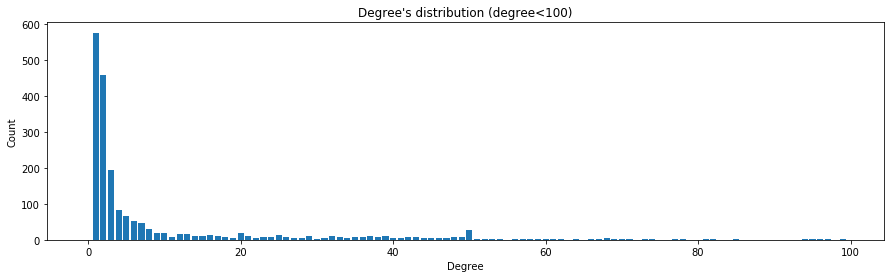

In [33]:
LIMIT = 100

degrees = nx.degree_histogram(spotify)[:LIMIT]
plt.figure(figsize=(15,4))
plt.bar(list(range(len(degrees))),degrees)
plt.title('Degree\'s distribution (degree<{:d})'.format(LIMIT))
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

### Diameter (length of the maximum path)

In [25]:
%time print("{:f}".format(nx.diameter(spotify)))

12.000000
Wall time: 3min 7s


### Closeness centrality

In [26]:
%time closeness = nx.closeness_centrality(spotify)
closeness_sorted = [(k, v) for k, v in sorted(closeness.items(), key=lambda item: item[1])]

Wall time: 3min 10s


In [27]:
print("The node with the lowest closeness value is {:s} with a value of {:f}".format(closeness_sorted[0][0], 
                                                           closeness_sorted[0][1]))
print("The node with the highest closeness value is {:s} with a value of {:f}".format(closeness_sorted[-1][0], 
                                                           closeness_sorted[-1][1]))

The node with the lowest closeness value is 4m0xrEWYU0yCUFMaga015T with a value of 0.125517
The node with the highest closeness value is 6eUKZXaKkcviH0Ku9w2n3V with a value of 0.355523


### Betweeness centrality

In [28]:
%time between = nx.betweenness_centrality(spotify)
between_sorted = [(k, v) for k, v in sorted(between.items(), key=lambda item: item[1])]

Wall time: 2min 2s


In [29]:
print("The node with the lowest betweeness value is {:s} with a value of {:f}".format(between_sorted[0][0], 
                                                           between_sorted[0][1]))
print("The node with the lowest betweeness value is {:s} with a value of {:f}".format(between_sorted[-1][0], 
                                                           between_sorted[-1][1]))

The node with the lowest betweeness value is 0f5nVCcR06GX8Qikz0COtT with a value of 0.000000
The node with the lowest betweeness value is 37i9dQZF1DX14l44D8IaLa with a value of 0.090416
